# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Для выполнения данной работы имеется набор фотографий людей с указанием возраста.

План проекта:
- исследовательский анализ набора фотографий.
- подготовка данных к обучению.
- обучение нейронной сети.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import warnings
import hashlib
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
warnings.filterwarnings('ignore')
R_STATE = 12345

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.info()
labels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

In [5]:
len(labels['real_age'].unique())

97

In [6]:
labels.real_age.value_counts().head(20)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
17    163
34    156
50    156
1     149
35    147
Name: real_age, dtype: int64

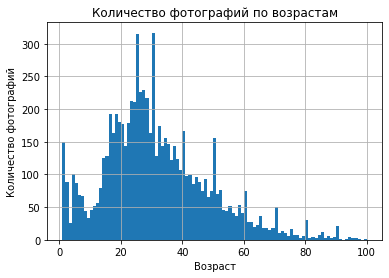

In [7]:
ax = labels.real_age.hist(bins=99)
ax.set(xlabel='Возраст', ylabel='Количество фотографий', title='Количество фотографий по возрастам');

Медиана (29 лет) и среднее (31,2) отличаются, что говорит о смещении распределения вправо: фотографий молодёжи меньше. Однако есть некоторые сомнения в предоставленных данных, связанные с необычными пиками около ноля, а так же в районе 50 и 60 лет: их можно будет рассеять, взглянув на фото. Но для начала стоит взглянуть на случайные фотографии.

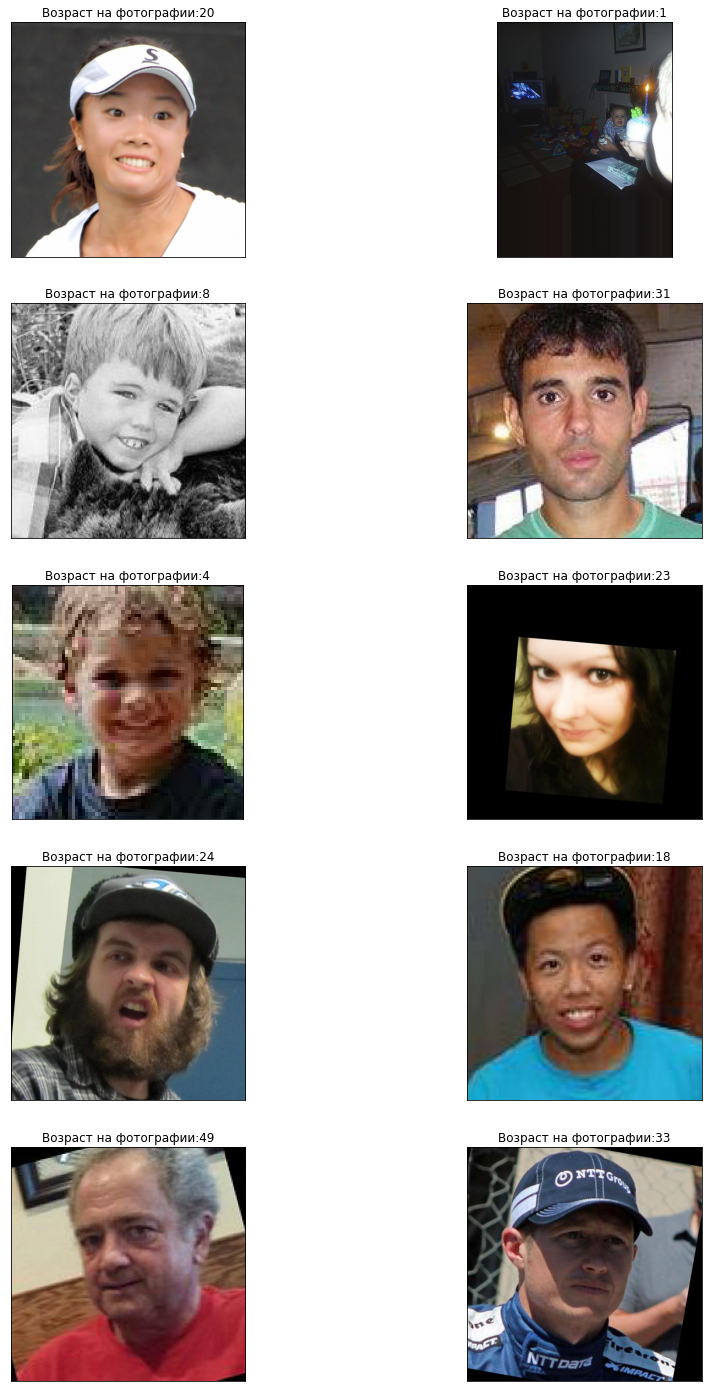

In [8]:
ax = None
plt.figure(figsize=(15,25))
for i in range(10):
    plt.subplot(5,2,i+1)
    pair = labels.sample(1)
    path = pair['file_name'].loc[pair.index[0]]
    image = Image.open('/datasets/faces/final_files/' + path)
    array = np.array(image)
    array = array / 255
    plt.xticks([])
    plt.yticks([])
    plt.imshow(array)
    plt.title('Возраст на фотографии:' + str(pair['real_age'].loc[pair.index[0]]))

На первый взляд ничего необычного, но стоит всё же взглянуть на странные пики. Кроме возраста около нуля (а именно 1 год) есть ещё удивительно много людей с круглой цифрой возраста - кроме 10 лет, где наблюдается, наоборот, провал, есть пики на 20, 30, 40, 50, 60, 70, 80 и даже 90 годах. Сложно сказать, является ли это следствием плохой разметки или тем, что это какие-то фотографии с юбилея - но для очистки совести нужно обязательно на них взглянуть.

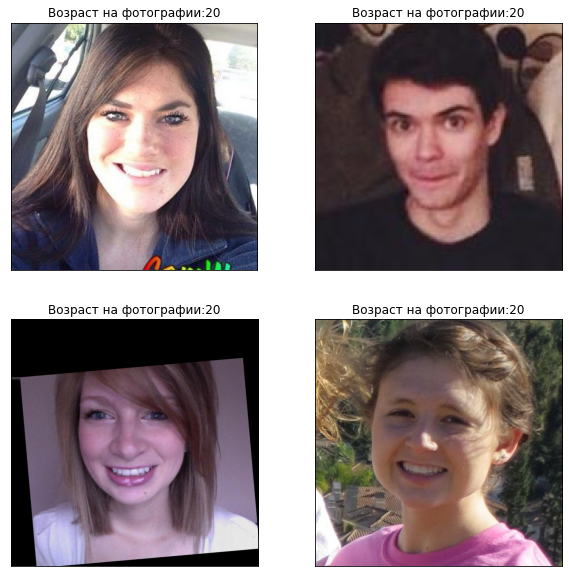

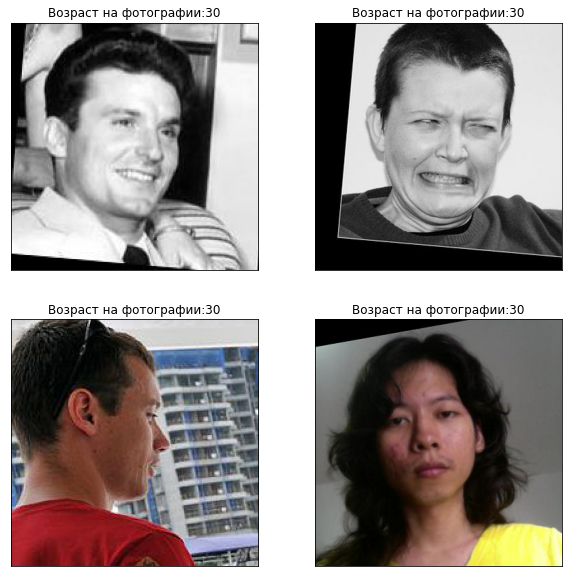

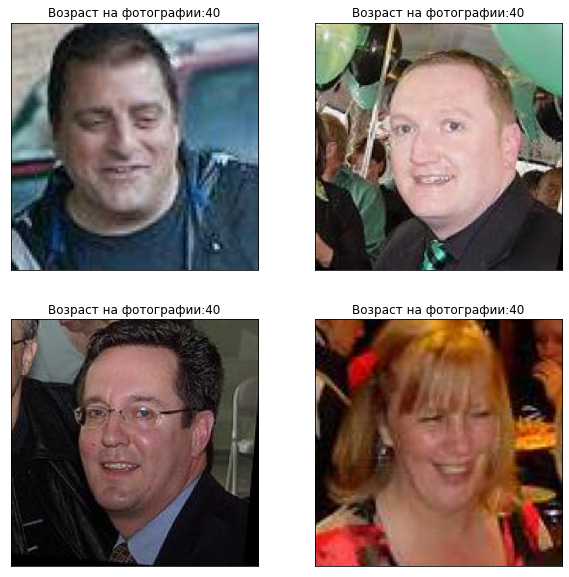

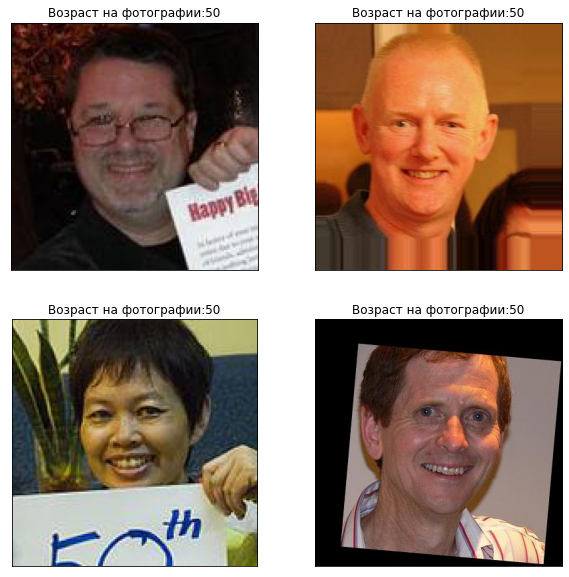

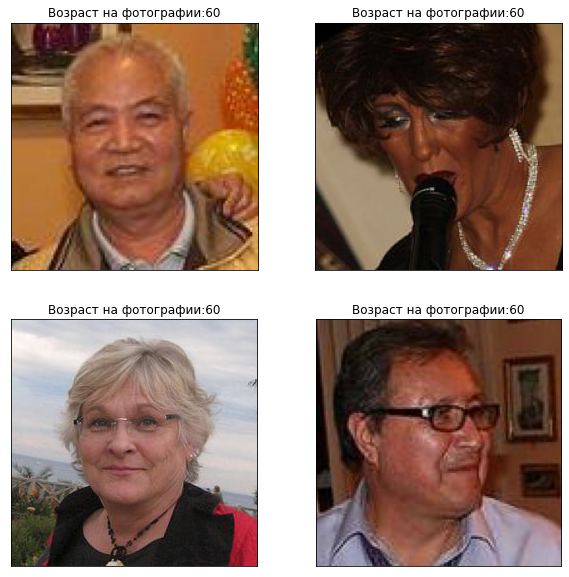

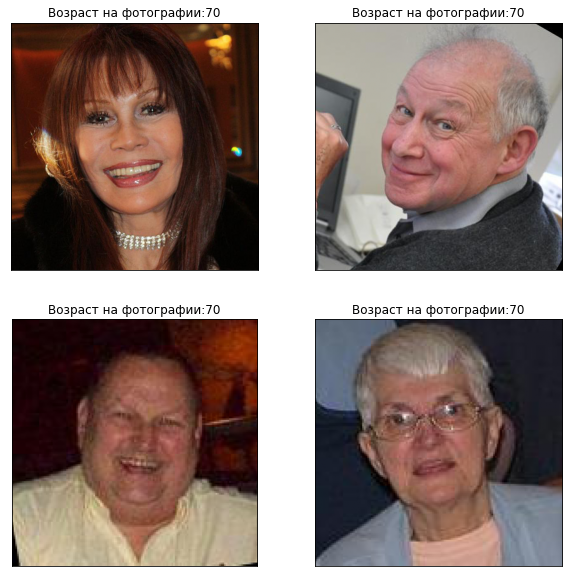

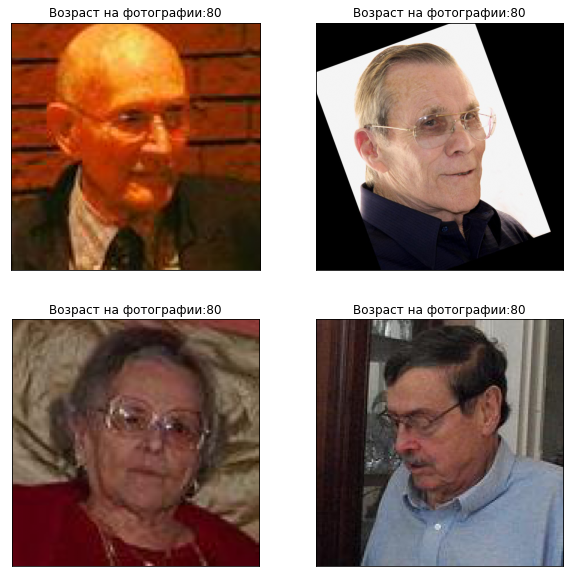

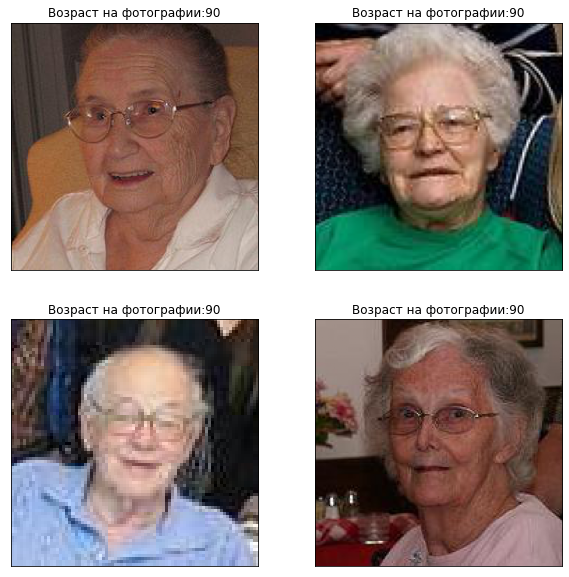

In [9]:

for age in [20, 30, 40, 50, 60, 70, 80, 90]:
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        pair = labels[labels['real_age'] == age].sample(1)
        path = pair['file_name'].loc[pair.index[0]]
        image = Image.open('/datasets/faces/final_files/' + path)
        array = np.array(image)
        array = array / 255
        plt.imshow(array)
        plt.xticks([])
        plt.yticks([])
        plt.title('Возраст на фотографии:' + str(pair['real_age'].loc[pair.index[0]]))

Совершенно точно не все фотографии соответствуют своему возрасту. Однако таких несоответствий немного, и их следует воспринимать как шум. Кроме того, обнаружилась ещё одна теория, объясняющая пики на цифрах возраста, оканчивающихся на 0 - это просто опечатка, когда вместо 8 могли написать 80, к примеру. Другой вопрос, что единственный способ избавиться от подобных артефактов - это перебор базы вручную, потому что сделать это автоматически не представляется возможным.

In [10]:
def hash_dataframe(df):
    BUFFER_SIZE = 16384
    hasher = hashlib.sha256()
    for ind in df.index:
        filename = df['full_path'][ind].encode('utf-8')
        with open(filename, 'rb') as f:
            buffer = f.read(BUFFER_SIZE)
        df['hash'][ind] = hashlib.sha1(buffer).hexdigest()

labels['full_path'] = '/datasets/faces/final_files/' + labels['file_name']
labels['hash'] = labels['file_name']
hash_dataframe(labels)
labels

file_name  real_age                               full_path  \
0     000000.jpg         4  /datasets/faces/final_files/000000.jpg   
1     000001.jpg        18  /datasets/faces/final_files/000001.jpg   
2     000002.jpg        80  /datasets/faces/final_files/000002.jpg   
3     000003.jpg        50  /datasets/faces/final_files/000003.jpg   
4     000004.jpg        17  /datasets/faces/final_files/000004.jpg   
...          ...       ...                                     ...   
7586  007608.jpg        14  /datasets/faces/final_files/007608.jpg   
7587  007609.jpg        37  /datasets/faces/final_files/007609.jpg   
7588  007610.jpg        28  /datasets/faces/final_files/007610.jpg   
7589  007611.jpg        20  /datasets/faces/final_files/007611.jpg   
7590  007612.jpg        47  /datasets/faces/final_files/007612.jpg   

                                          hash  
0     773b496c91a60c584a638d8e36d67f5bcb6068af  
1     de49e31836c687e4c4519fab82b59da56f221a78  
2     a1ab3f04dfcc558958e4d531b59404776b1b2aaf  
3     69e7ca19586de5391a893a1a902516dd73066353  
4     91bbd68d0fced0e9ef38685d0906065919d863e1  
...                                        ...  
7586  8a7d37df1a4ff6f91e6af1d78f5c917adb150003  
7587  b0ca6a86451a530bd46707fd864a643c759f676a  
7588  0404940652269406d17efe7cccc0fd29d1fd3fc8  
7589  cec8d3212970518af78c0d19b1ca4b08b9862be6  
7590  b5e3ddb7e730a78293f7ee38d4f9b63017f10110  

[7591 rows x 4 columns]

In [11]:
duplicates = list(labels.loc[labels['hash'].duplicated(keep=False), 'file_name'])
duplicates

['001601.jpg', '005998.jpg']

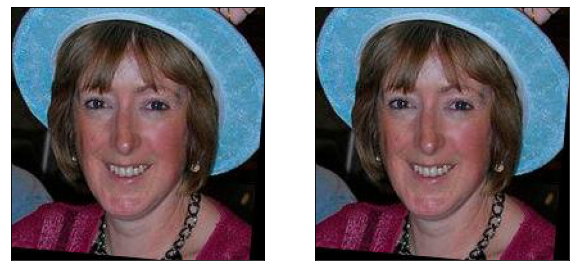

In [12]:
i = 1

plt.figure(figsize=(10,10))
plt.title('Дубликаты')
for file in duplicates:
        plt.subplot(1,2,i)
        image = Image.open('/datasets/faces/final_files/' + file)
        array = np.array(image)
        array = array / 255
        plt.imshow(array)
        plt.xticks([])
        plt.yticks([])
        
        i+= 1

Кроме всего прочего был обнаружен дубликат, от которого стоит избавиться.

In [13]:
labels = labels.drop_duplicates(['hash'])
labels

file_name  real_age                               full_path  \
0     000000.jpg         4  /datasets/faces/final_files/000000.jpg   
1     000001.jpg        18  /datasets/faces/final_files/000001.jpg   
2     000002.jpg        80  /datasets/faces/final_files/000002.jpg   
3     000003.jpg        50  /datasets/faces/final_files/000003.jpg   
4     000004.jpg        17  /datasets/faces/final_files/000004.jpg   
...          ...       ...                                     ...   
7586  007608.jpg        14  /datasets/faces/final_files/007608.jpg   
7587  007609.jpg        37  /datasets/faces/final_files/007609.jpg   
7588  007610.jpg        28  /datasets/faces/final_files/007610.jpg   
7589  007611.jpg        20  /datasets/faces/final_files/007611.jpg   
7590  007612.jpg        47  /datasets/faces/final_files/007612.jpg   

                                          hash  
0     773b496c91a60c584a638d8e36d67f5bcb6068af  
1     de49e31836c687e4c4519fab82b59da56f221a78  
2     a1ab3f04dfcc558958e4d531b59404776b1b2aaf  
3     69e7ca19586de5391a893a1a902516dd73066353  
4     91bbd68d0fced0e9ef38685d0906065919d863e1  
...                                        ...  
7586  8a7d37df1a4ff6f91e6af1d78f5c917adb150003  
7587  b0ca6a86451a530bd46707fd864a643c759f676a  
7588  0404940652269406d17efe7cccc0fd29d1fd3fc8  
7589  cec8d3212970518af78c0d19b1ca4b08b9862be6  
7590  b5e3ddb7e730a78293f7ee38d4f9b63017f10110  

[7590 rows x 4 columns]

In [14]:
labels = labels.drop(['full_path', 'hash'], axis=1)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=R_STATE) 

Подытоживая результаты анализа предоставленных данных, следует отметить следующее:

- разметка датасета имеет изъяны, и это скажется на качестве модели
- распределение возрастов в датасете неоднородное, что приведёт к тому, что модель будет лучше определять более часто встречающиеся в датасете значения

## Обучение модели

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, 
    rotation_range=15,
    horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345) 
   
    return train_datagen_flow
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return test_datagen_flow
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
              metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 110s - loss: 206.3694 - mae: 10.4528 - val_loss: 559.9424 - val_mae: 18.3899
Epoch 2/20
356/356 - 105s - loss: 94.9054 - mae: 7.3902 - val_loss: 163.2519 - val_mae: 9.5911
Epoch 3/20
356/356 - 106s - loss: 71.8001 - mae: 6.4803 - val_loss: 139.5092 - val_mae: 8.9712
Epoch 4/20
356/356 - 106s - loss: 58.9856 - mae: 5.9241 - val_loss: 80.2243 - val_mae: 6.6967
Epoch 5/20
356/356 - 104s - loss: 47.6901 - mae: 5.3444 - val_loss: 84.1404 - val_mae: 6.9172
Epoch 6/20
356/356 - 96s - loss: 40.0055 - mae: 4.8925 - val_loss: 88.3122 - val_mae: 6.9627
Epoch 7/20
356/356 - 99s - loss: 33.8928 - mae: 4.4388 - val_loss: 80.8058 - val_mae: 6.5555
Epoch 8/20
356/356 - 106s - loss: 27.8603 - mae: 4.0726 - val_loss: 74.9278 - val_mae: 6.2910
Epoch 9/20
356/356 - 107s - loss: 25.2337 - mae: 3.8721 - val_loss: 66.1800 - val_mae: 6.0680
Epoch 10/20
356/356 - 107s - loss: 22.8805 - mae: 3.6857 - val_loss: 71.3882 - val_mae: 6.1751
Epoch 11/20
356/356 - 106s - loss: 20.8419 - mae: 3.4896 - val_loss: 68.1951 - val_mae: 6.0020
Epoch 12/20
356/356 - 102s - loss: 18.4541 - mae: 3.2710 - val_loss: 67.3740 - val_mae: 6.0892
Epoch 13/20
356/356 - 99s - loss: 18.0522 - mae: 3.2554 - val_loss: 69.4979 - val_mae: 6.1053
Epoch 14/20
356/356 - 106s - loss: 16.2800 - mae: 3.0753 - val_loss: 67.4265 - val_mae: 5.9780
Epoch 15/20
356/356 - 105s - loss: 16.2048 - mae: 3.0787 - val_loss: 64.7688 - val_mae: 5.9283
Epoch 16/20
356/356 - 106s - loss: 15.2093 - mae: 2.9661 - val_loss: 70.9258 - val_mae: 6.3074
Epoch 17/20
356/356 - 104s - loss: 14.6268 - mae: 2.9211 - val_loss: 64.8708 - val_mae: 5.8745
Epoch 18/20
356/356 - 93s - loss: 12.7707 - mae: 2.7263 - val_loss: 64.5668 - val_mae: 5.9939
Epoch 19/20
356/356 - 90s - loss: 12.3425 - mae: 2.6845 - val_loss: 66.2038 - val_mae: 6.0210
Epoch 20/20
356/356 - 90s - loss: 12.6210 - mae: 2.7040 - val_loss: 63.2189 - val_mae: 5.9437

119/119 - 10s - loss: 63.2189 - mae: 5.9437
Test MAE: 5.9437

```

## Анализ обученной модели

Для обучения была выбрана архитектура ResNet50, однако для получения более точных предсказаний была использована аугментация (горизонтальное отражение и наклон в пределах 15 градусов), а настройки оптимизатора были изменены (lr = 0.0001): уменьшение шага возможно замедлило обучение модели, однако значение MAE на тестовой выборке было получено с запасом - 5.9437, а нужная точность (< 8) была достигнута ещё после четвёртой эпохи.
Полученное значение метрики можно интерпретировать следующим образом - обученная сеть ошибается в среднем меньше чем на 6 лет при определении возраста человека по фотографии, что может быть критично большой величиной при контроле продажи алкоголя и табака, но для составления предложений, которые могут заинтересовать покупателей определённой возрастной группы её вполне можно рекомендовать.

Нужно упомянуть, что улучшить качество предсказаний модели можно увеличив размер обучаемого датасета (подобную информацию можно получить, сопоставляя снимки с камер с данными клиентов-держателей персональных карт), а так же поработав над разметкой уже существующего датасета, который содержит неточности и даже повторы.